# Regression

So far our target ($y$) has always been of categorical type, i.e., we have been doing classification. However, it is very likely that one encounters situations where the target is continuous for example the previous example with incomes would have made much more sense with continuous target. We shall limit ourselves to situations where the target is a single value though there is no inherent reason why this would be the case. That is, we try to predict using item $\mathbf{x}$ the target value $y \in \mathbb{R}$. Since most have already been in courses of statistics you guessed it - we shall be first doing linear regression, but soon present tree regressor and random forest regressors as well (we'll see about that). Notice also, that while in statistics regression is often used as synonym to linear regression for us it only means situations where we try to predict the values of continuous variable, regardless of the underlying method.
***
#### What:
1. Linear regression.
2. How to find the parameters in linear regression?
4. Gradient descent...? Some minimization anyway...
5. Tree regressor and RF regressors.
6. Examples of applying regressors - predicting.
***
#### Def 1. A computer program is said to learn from *experience* **E** with respect to some class of *tasks* **T** and *performance measure* **P**, if its performance at tasks in **T** as measured by **P**, improves with experience **E**. 

-Mitchell, T. (1997). Machine Learning.

In [1]:
# Import the required libraries
import pandas as pd # Pandas deals with handling data. 
import numpy as np # Numpy provides a lot of FAST ways for array manipulation in python.
import matplotlib.pyplot as plt # Plotting script library
import matplotlib as mpl # Plotting
import seaborn as sns # More plotting

%matplotlib inline 
# Define some plotting params:
mpl.rcParams['figure.figsize'] = (12,6)
sns.set_style("whitegrid", {"axes.facecolor": ".99"})
sns.set_style("ticks")

data = sns.load_dataset('penguins').dropna()
target = 'species'
xlabel = 'bill_length_mm'
ylabel = 'bill_depth_mm'

### Training supervised regressor using scikit-learn:

Let us start by just applying the linear regressor ([LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)) from sklearn to predict 'bill_depth_mm' Gentoo penguins given the 'bill_length_mm'. Recall Linear models:

$
y = \mathbf{w} \cdot \mathbf{x} + b, 
$

where $\mathbf{w} = [w_1,\dots,w_{\text{dim}(\mathbf{x})}]$ are the parameters of the model and $b$ is the bias. The model is actually affine since there is bias included.

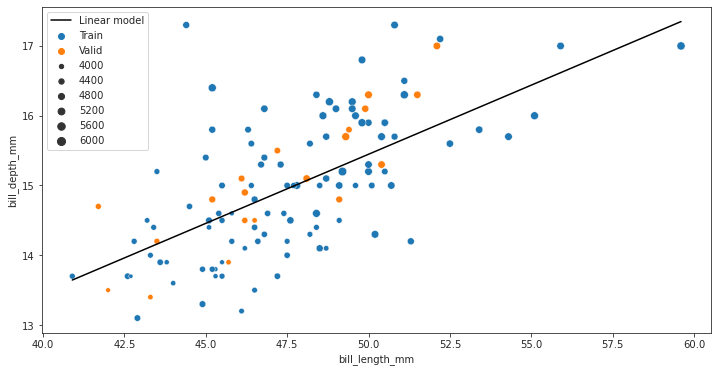

In [25]:
from sklearn.model_selection import train_test_split

# select only single species from the data
species = 'Gentoo'
mask = data.species == species
data_gentoo = data[mask]

# Select only species
X = data_gentoo.loc[:, xlabel].values.reshape(-1, 1)
y = data_gentoo.loc[:, ylabel].values

# Pick the validation set randomly:
valid_idx = np.random.choice(len(X), size=20, replace=False)

# Train valid mask:
trainvalid = np.zeros(len(X), dtype=bool)
trainvalid[valid_idx] = True

# Import the linear regression model
from sklearn.linear_model import LinearRegression


# We fit the linear model to training data:
linreg = LinearRegression().fit(X[~trainvalid, :], y[~trainvalid])

ax = sns.scatterplot(data=data_gentoo, 
                     x=xlabel, 
                     y=ylabel, 
                     hue=[{0:'Train', 1:'Valid'}[tr] for tr in trainvalid], 
                     palette={'Train':'C0', 'Valid':'C1'},
                     size='body_mass_g')

xmin = data_gentoo.loc[:, xlabel].min()
xmax = data_gentoo.loc[:, xlabel].max()
ymin = data_gentoo.loc[:, ylabel].min()
ymax = data_gentoo.loc[:, ylabel].max()

xrange = np.linspace(xmin, xmax, 20)
ax.plot(xrange, linreg.coef_[0]*xrange + linreg.intercept_, color='black', label='Linear model')

_ = plt.legend()

### Discussion:

In statistics it is not common (?) to use 'valid sets' to estimate the goodness of a model  fit (here model = linear regression) - why do we do it now? The reason is that statisticians make (analytical) models - they have (hopefully) well grounded reasons to believe that their model ought to work, or they are in a process of testing if it works. They understand the risks of having a lot of free parameters and implement serious protections to not fool themselves:

#### "*The first principle is that you must not fool yourself — and you are the easiest person to fool.*"

-Richard Feynmann

If a test statistic measuring the goodness of a fit of statistical model $M$ in the dataset tells that model $M$ indeed seems to explain the data statisticians are happy - they have managed to produce understanding (in form of the mathematical model $M$) and the phenomena under consideration is 'explained'. On the other hand in ML you do not often seek to produce understanding of the process generating the data you work with. I mean, does an ann fitted to predict pet breeds give you any additional insights in understanding pet breeds - quite often no. Does it predict from give item which pet breed there is in the image - most often yes. What you are seeking after are *predictions* about unseen data items that you expect to receive and on the goodness of those predictions. Hence, you also are not certain that even if you manage to fit you model into your *training data* that it works in the *real world*. You see, statistician actually understood what is going on, and thus also know the limitations of the model and where to apply it - you do not possess such a luxury, the only way to make sanity checks about your ML model is to test it in the validation data.

An important thing to note is that sampling the validation/test sets is not always as straightforward as here. When picking the validation and test sets think that they ought to represent the data you are going to encounter in the runtime. Think if your validation/test sets actually represent something you would see in the deployment environment and try not to fool yourselves! However, such considerations are outside the scope for us for now.

***
### If you are not careful this can happen:

The talk about models and 'understanding' is rather vague, after all there is no much room for ML in the above example in the first place. Let us anyhow show what might happen if you get a bit carried away with you linear regression and only consider the goodness of the fit in the training data.

We take the same dataset as before, but 'augment' it to also include powers of the xlabel to obtain better fits in the training data:

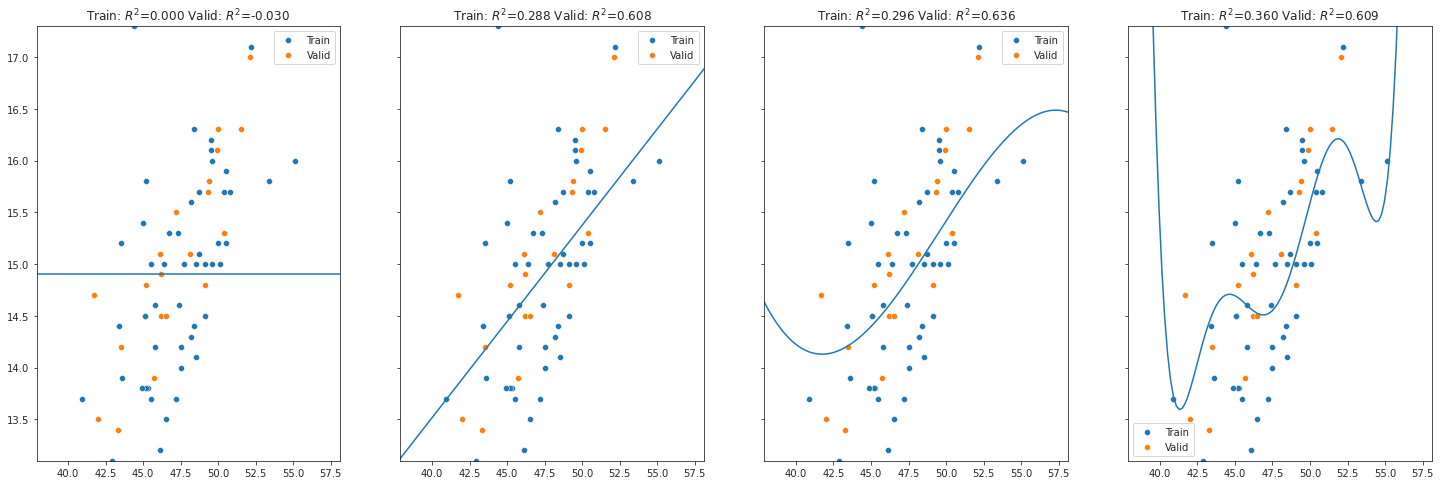

In [65]:
from sklearn.preprocessing import PolynomialFeatures


_, axarr = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(25, 8))
X_train = X[trainvalid==0][::2]
X_valid = X[trainvalid==1]
y_train = y[trainvalid==0][::2]
y_valid = y[trainvalid==1]


for degree, ax in zip([0, 1, 3, 6], axarr.flatten()):
    poly = PolynomialFeatures(degree=degree)
    
    X_train_aug = poly.fit_transform(X_train)
    linreg.fit(X_train_aug, y_train)
    
    sns.scatterplot(x=X_train.flatten(), y=y_train, ax=ax, label='Train')
    sns.scatterplot(x=X_valid.flatten(), y=y_valid, ax=ax, label='Valid')
    
    
    X_valid_aug = poly.transform(X_valid)
    xrange = np.linspace(xmin-5, xmax+5, 150).reshape(-1, 1)
    
    X_plot = poly.transform(xrange)
    y_pred = linreg.predict(X_plot)
    
    ax.plot(xrange, y_pred, label='Fit, degree={}'.format(degree))
    
    # Notice that linreg carries its own score function with it:
    R2_train = linreg.score(X_train_aug, y_train)
    R2_valid = linreg.score(X_valid_aug, y_valid)
    
    ax.set_title(r'Train: $R^2$={:.3f} Valid: $R^2$={:.3f}'.format(R2_train, R2_valid))
    ax.set_ylim([ymin, ymax])
    ax.set_xlim([X_train.min()-3, X_train.max()+3])

In the above, which of the models overfitted and which underfitted? Notice also, that the sole reason for us being able to see that the model on the right and left are bad (apart from maybe the $R^2$ scores for underfitted one) is that we plot the fit and the data - in reality there are dozens if not hundreds of dimensions, there is no hope for one to be able to visually inspect if the ML model fit is reasonable or not.

The thing is with dozens, hundreds or millions (neural networks) of free parameters in a flexible enough model you are basically able to capture whatever you aim (for example those pet breeds). Part of the challenge is not to capture *only* the thing you present but also *generalize* well outside the training data.

#### "*With four free parameters I can fit an elephant, and with five I can make it wiggle its trunk*" 

-John von Neumann

And that is not to say that free parameters are cool and great thing (at least outside ML)... The validation set is for us to figure out the right number of parameters to build the ml model. You do not want to (over)fit you model to the single elephant wiggling its trunk if the aim is to classify elephants in general! Also you need enough parameters to fit that elephant; even von Neumann did not claim he can do it with only two free parameters!
***

## Finding parameters:

What we are basically left to do is to understand how the LinearRegressor can find the coefficients ($\mathbf{w}$) it uses. If we can understand that we are more or less done in the business of ML including the neural networks (at least we hae rough idea what is happening conceptually ;)). We are actually pretty close since we already in the above had the $R^2$ score as an estimate for the goodness of the LinReg fit. Obviously, the task is to find parameters $\mathbf{w}$ so that the $R^2$ score is maximized - let us do exactly that. Before though, we show how one can, using a concept called gradient, figure out a appropriate update step for the model parameters given the current parameters and a loss or score function. Gradient of function $f(\mathbf{x})$ (here $\mathbf{x} \in \mathbb{R}^n$) is (we assume $f$ behaves resonably i.e., it is continuous in $\mathbf{x}$ etc.):

$
\text{grad}f(\mathbf{x}) =: \nabla f([x_1,\dots,x_n]) = [\frac{\partial}{\partial x_1}f(\mathbf{x}), \dots, \frac{\partial}{\partial x_n}f(\mathbf{x})].
$

For any point $\mathbf{x} + \delta \mathbf{x}$ close to $\mathbf{x}$ it holds:

$
f(\mathbf{x} + \delta \mathbf{x}) \approx f(\mathbf{x}) + \nabla f(\mathbf{x}) \cdot \delta \mathbf{x}.
$

To have the largest decrease after step $\delta\mathbf{x}$ we have to have $\delta\mathbf{x} || \nabla f(\mathbf{x})$ and specifically for decrese we use:
$
\delta\mathbf{x} = -l_r \nabla f(\mathbf{x}),
$
where $l_r$ is called learning rate. It is important to remember that the approximate eq. only holds if $\text{norm}(\delta\mathbf{x})$ is small and hence $l_r$ needs to be picked appropriately. Anyhow, we see that we can gradually move towards the minimum of $f(\mathbf{x})$ if we just at each step $i$ (do not confuse this with the component index) update the current:

$
\mathbf{x}_{i+1} \rightarrow \mathbf{x}_i - l_r \nabla f(\mathbf{x}_i).
$ 
***
Lets now implement this and see what happens: 

In [51]:
def get_grad(func, w, dw, *args):
    """
    How does the value of func change when we modify each component of 
    w by dw:
    
    Never implement this kind of (mathematical) functions yourself unless for 
    demonstration purposes only. They exist in libraries are are 
    done way better there!
    """
    ngrad = np.zeros(len(w))
    # loop over the w parameters:
    for i in range(len(w)):
        # copy the original array:
        wdw = w.copy()
        # modify the parameter at index i:
        wdw[i] += dw
        # Check how the function value changes and divide by the dw value, i.e., when lim dw --> 0 this is the derivative of func at point w.r.t. w[i]:
        ngrad[i] = (func(wdw, *args) - func(w, *args))/dw
        
    return ngrad

#### Simple example for gradient descent:

Let us using the get_grad() find a minimum for function func as described above:

In [66]:
func = lambda x: x**2

# Specify the learning rate:
lr = .01

# Initial quess for minima:
x = np.array([1.])

# N steps to take:
N = 50

# progress table for plotting the results:
progress = np.zeros((N, 4))

# loop and take gradient descent step at each iteration:
for i in range(N):
    
    # Get the gradient at current point:
    grad = get_grad(func, np.array([x]), .00001)
    
    # Step in x is the grad * learning rate
    stepx = -grad*lr
    
    # The anticipated step in y is, however, this is only approximation.
    stepy = np.dot(grad, stepx)
    
    # Store the progress for plotting...
    progress[i,:] = x, func(x), stepx, stepy 
    
    # Update the position:
    x += stepx #lr*grad
    
animate_descent(progress, func, np.linspace(-.2, 1, 20))     

## Lets then apply this machinery to find the linreg coefficients:

In [64]:
X_train = X[trainvalid==0]
X_valid = X[trainvalid==1]
y_train = y[trainvalid==0]
y_valid = y[trainvalid==1]

def set_linreg_params(linreg, w):
    """
    Helper to set the linreg params:
    """
    # Set the coefficients:
    linreg.coef_ = w[:-1]
    # Set the intercept
    linreg.intercept_ = w[-1]
    
    return linreg

def get_R2(w, X, y, linreg):
    """
    Get the NEGATIVE R^2 score of the lin regressor with params w:
    Negative so that we can minimize it...
    """    
    linreg = set_linreg_params(linreg, w)
    
    return -linreg.score(X, y)



# Initial quess for the linreq coefficients:
w = np.array([0.0, 0.0], dtype=float)

# Learning rate - you need to be bit careful with this:
lr = .00005 #.0001

# Number of steps to take:
N = 30

# Array to store progress:
wprogress = np.zeros((N, 3))

# Iterate over N steps:
for i in range(N):
    
    # Put the linreq params in place:
    linreg = set_linreg_params(linreg, w)
    
    # Get the gardient att current point - w:
    wg = get_grad(get_R2, w, .000001, X_train, y_train, linreg)
    
    # Store progress:
    wprogress[i, :] = *w, -linreg.score(X_train, y_train)
    
    # Update the current point by the gradient descent step:
    w -= wg*lr
    
animate_linreg(wprogress, X_train, y_train)  

## What on earth this has to do with neural networks?!?

Earlier I said you would be done in the business of neural networks as well if you just crasped the gradient descent. How is this parameter optimization related to fitting an ann to images of pets? You see, in our linear model we have only two parameters ($w, b$) and we 'fit' them so that the score ($R^2$) of the fit to training data is maximised. We use gradient descent to wind the optimal parameters (actually we minimized the $-R^2$, but that is only matter of choice...):

$
(w_\text{opt}, b_\text{opt}) = \underset{(w, b)}{\arg \max} R^2(\text{LinReg}(w, b, X_\text{train}), y_\text{train}).
$

We can use the same technigues to optimize the parameters $\mathbf{W}$ of any model (yes can be ann) $\mathcal{M}_\mathbf{W}$. Having some appropriate loss function $L$:

$
\mathbf{W}_\text{opt} = \underset{\mathbf{W}}{\arg \min} L(\mathcal{M}_\mathbf{W}(X_\text{train}), y_\text{train}),
$

maybe needless to say that there are quite a few details on the way, but once you have specified your loss $L$ (the loss also needs to behave 'nicely' when the parameters are changed), your model $\mathcal{M}_\mathbf{W}$, and you have labeled training data, you may start to find the optimal parametrs using gradient descent. In some cases you can also skip the training data labels! The loss does not need to depend in $y$...

#### Questions:
1. Say you had a time series data where you would be interersted in some quantity in the future, how would you then pick the training and validation sets? 


In [62]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import rc

rc('animation', html='jshtml') #, html='html5')

def animate_descent(progress, fun, xrange):
    
    fig, ax = plt.subplots()
    
    # Lines to plot
    dx, = ax.plot([], [], '-', color='C0', lw=2)
    dy, = ax.plot([], [], '-', color='C0', lw=2)
    
    
    scat = ax.scatter([], [], label='steps')
    
    def init():
        
        # Init the axeses:
        ax.plot(xrange, fun(xrange), color='C1', label='Fun')
        
        return dx, dy, scat, 

    def update(frame):
        
        
        x, y, dx_, dy_ = progress[frame, :]
        
        # Update the line points
        dx.set_data([x, x+dx_], [y, y])
        dy.set_data([x+dx_, x+dx_], [y, y+dy_])
        
        X = np.c_[progress[:frame+1, 0], progress[:frame+1, 1]]
        scat.set_offsets(X)
        #scat.set_offsets(progress[:frame, 0], progress[:frame, 1])
        
        
        return dx, dy, scat, 

    ani = FuncAnimation(fig, update, 
                        frames=np.arange(len(progress)), 
                        interval=int(10000/len(progress)),
                        init_func=init, blit=True)
    
    plt.close() # Remove the otherwise annoying extra plot..
    return HTML(ani.to_jshtml())

def animate_linreg(w, X_train, y_train):
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    
    # Lines to plot
    ln_pred, = ax1.plot([], [], '-', color='C0', lw=1, label='Estim')
    ln_params, = ax2.plot([], [], '-o', color='C0', lw=1, label='Score')
    ln_score, = ax3.plot([], [], '-o', color='C0', lw=1, label='Score')
    
    
    x = X_train.flatten()
    ax1.scatter(x, y_train, label='Train instances', c='C0')
    hist = 5
    
    
    
    def init():
        
        # Init the axeses:
        
        ax1.legend()
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)
        ax1.set_title('Dataa and fit:')
        
        ax3.legend()
        ax3.set_xlim([0, len(w)])
        ax3.set_ylim([-1, w[:, 2].max()])
        ax3.set_xlabel('N steps')
        ax3.set_ylabel(r'-R^2 score')
        ax3.set_title('-R^2 Score')
        #ax3.semilogy()
        
        ax2.set_xlim([w[:, 0].min(), w[:, 0].max()])
        ax2.set_ylim([w[:, 1].min(), w[:, 1].max()])
        ax2.set_xlabel('w')
        ax2.set_ylabel('Intercept')
        ax2.set_title('LinReg params')
        
        return ln_pred, ln_score, ln_params,  

    def update(frame):
        
        a = w[frame, 0]
        b = w[frame, 1]
        
        # Update the line points
        ln_pred.set_data(x, a*x + b)
        ln_score.set_data(range(frame+1), w[:(frame+1), 2])
        ln_params.set_data(w[:frame, 0], w[:frame, 1])
        
        #if frame > hist:
        #    # Update the limits:
        #    ax2.set_xlim([w[frame-5:frame, 0].min(), w[frame-5:frame, 0].max()])
        #    ax2.set_ylim([w[frame-5:frame, 1].min(), w[frame-5:frame, 1].max()])
        #    ax3.set_xlim([frame-hist, frame])
        #    ax3.set_ylim([w[frame-hist:frame, 2].min(), w[frame-hist:frame, 2].max()])
        
        
        return ln_pred, ln_score, ln_params, 

    ani = FuncAnimation(fig, update, 
                        frames=np.arange(len(w)), 
                        interval=int(10000/len(w)),
                        init_func=init, blit=True)
    
    plt.close() # Remove the otherwise annoying extra plot..
    return HTML(ani.to_jshtml())